In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from VegasAfterglow import ObsData, Setups, Fitter, ParamDef, Scale

In [5]:
# 1. Prepare data
data = ObsData()
band = [2.4e17, 4.84e14, 1.4e14]
lc_files = ["data/ep.csv", "data/r.csv", "data/vt-r.csv"]

for nu, fname in zip(band, lc_files):
    df = pd.read_csv(fname)
    data.add_light_curve(nu_cgs=nu, t_cgs=df["t"], Fnu_cgs=df["Fv_obs"], Fnu_err=df["Fv_err"])

times = [3000]
spec_files = ["data/ep-spec.csv"]    
for t, fname in zip(times, spec_files):
    df_spec = pd.read_csv(fname)
    data.add_spectrum(t_cgs=t, nu_cgs=df_spec["nu"],
                      Fnu_cgs=df_spec["Fv_obs"], Fnu_err=df_spec["Fv_err"])

# 2. Configure model
cfg = Setups()
cfg.lumi_dist = 3.364e28
cfg.z         = 1.58
cfg.medium    = "wind"
cfg.jet       = "powerlaw"

# 3. Define parameter
mc_params = [
    ParamDef("E_iso",    1e52,  1e50,  1e54,  Scale.LOG),
    ParamDef("Gamma0",     30,     5,  1000,  Scale.LOG),
    ParamDef("theta_c",   0.2,   0.0,   0.5,  Scale.LINEAR),
    ParamDef("theta_v",   0.,  None,  None,   Scale.FIXED),
    ParamDef("p",         2.5,     2,     3,  Scale.LINEAR),
    ParamDef("eps_e",     0.1,  1e-2,   0.5,  Scale.LOG),
    ParamDef("eps_B",    1e-2,  1e-4,   0.5,  Scale.LOG),
    ParamDef("A_star",   0.01,  1e-3,     1,  Scale.LOG),
    #ParamDef("n_ism",   0.01,  1e-3,     10, Scale.LOG),
    ParamDef("xi",        0.5,  1e-3,     1,  Scale.LOG),
]

fitter = Fitter(data, cfg)

result = fitter.fit(
    mc_params,
    total_steps=50000
)

print("Best-fit parameters:")
for name, val in zip(result.labels, result.best_params):
    print(f"  {name}: {val:.4f}")

100%|██████████| 1000/1000 [00:03<00:00, 319.12it/s]

Best-fit parameters:
  E_iso: 52.7716
  Gamma0: 1.3650
  theta_c: 0.3361
  p: 2.3839
  eps_e: -1.4012
  eps_B: -1.1068
  A_star: -2.0257
  xi: -1.8345


In [6]:
t_out = np.logspace(2,9,150)
nu_out = np.logspace(6,20,150)
lc = fitter.light_curves(result.best_params, t_out, band)
spec = fitter.spectra(result.best_params, nu_out, times)

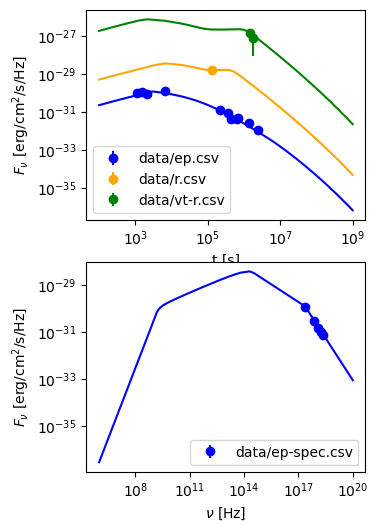

In [8]:
def draw_bestfit(t,lc_fit, nu, spec_fit):
    lc_files = ["data/ep.csv", "data/r.csv", "data/vt-r.csv"]
    spec_files = ["data/ep-spec.csv"]
    nus = [2.4e17, 4.84e14, 1.4e14]
    ts = [3000]

    fig =plt.figure(figsize=(4.5*0.8, 7.5*0.8))

    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    shift = [1,1,200]
    colors = ['blue', 'orange', 'green']
    for i, file, sft, c in zip(range(len(lc_files)), lc_files, shift, colors ):
        df = pd.read_csv(file)
        ax1.errorbar(df["t"], df["Fv_obs"]*sft, df["Fv_err"]*sft, fmt='o',label=file, color=c)
        ax1.plot(t, np.array(lc_fit[i])*sft, color=c)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax1.legend()
  
    for i, file, sft, c in zip(range(len(spec_files)), spec_files, shift, colors ):
        df = pd.read_csv(file)
        ax2.errorbar(df["nu"], df["Fv_obs"]*sft, df["Fv_err"]*sft, fmt='o',label=file, color=c)
        ax2.plot(nu, np.array(spec_fit[i])*sft, color=c)

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$\nu$ [Hz]')
    ax2.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax2.legend()

draw_bestfit(t_out, lc, nu_out, spec)
   

📊 Corner plot saved to: corner_plot_g.png


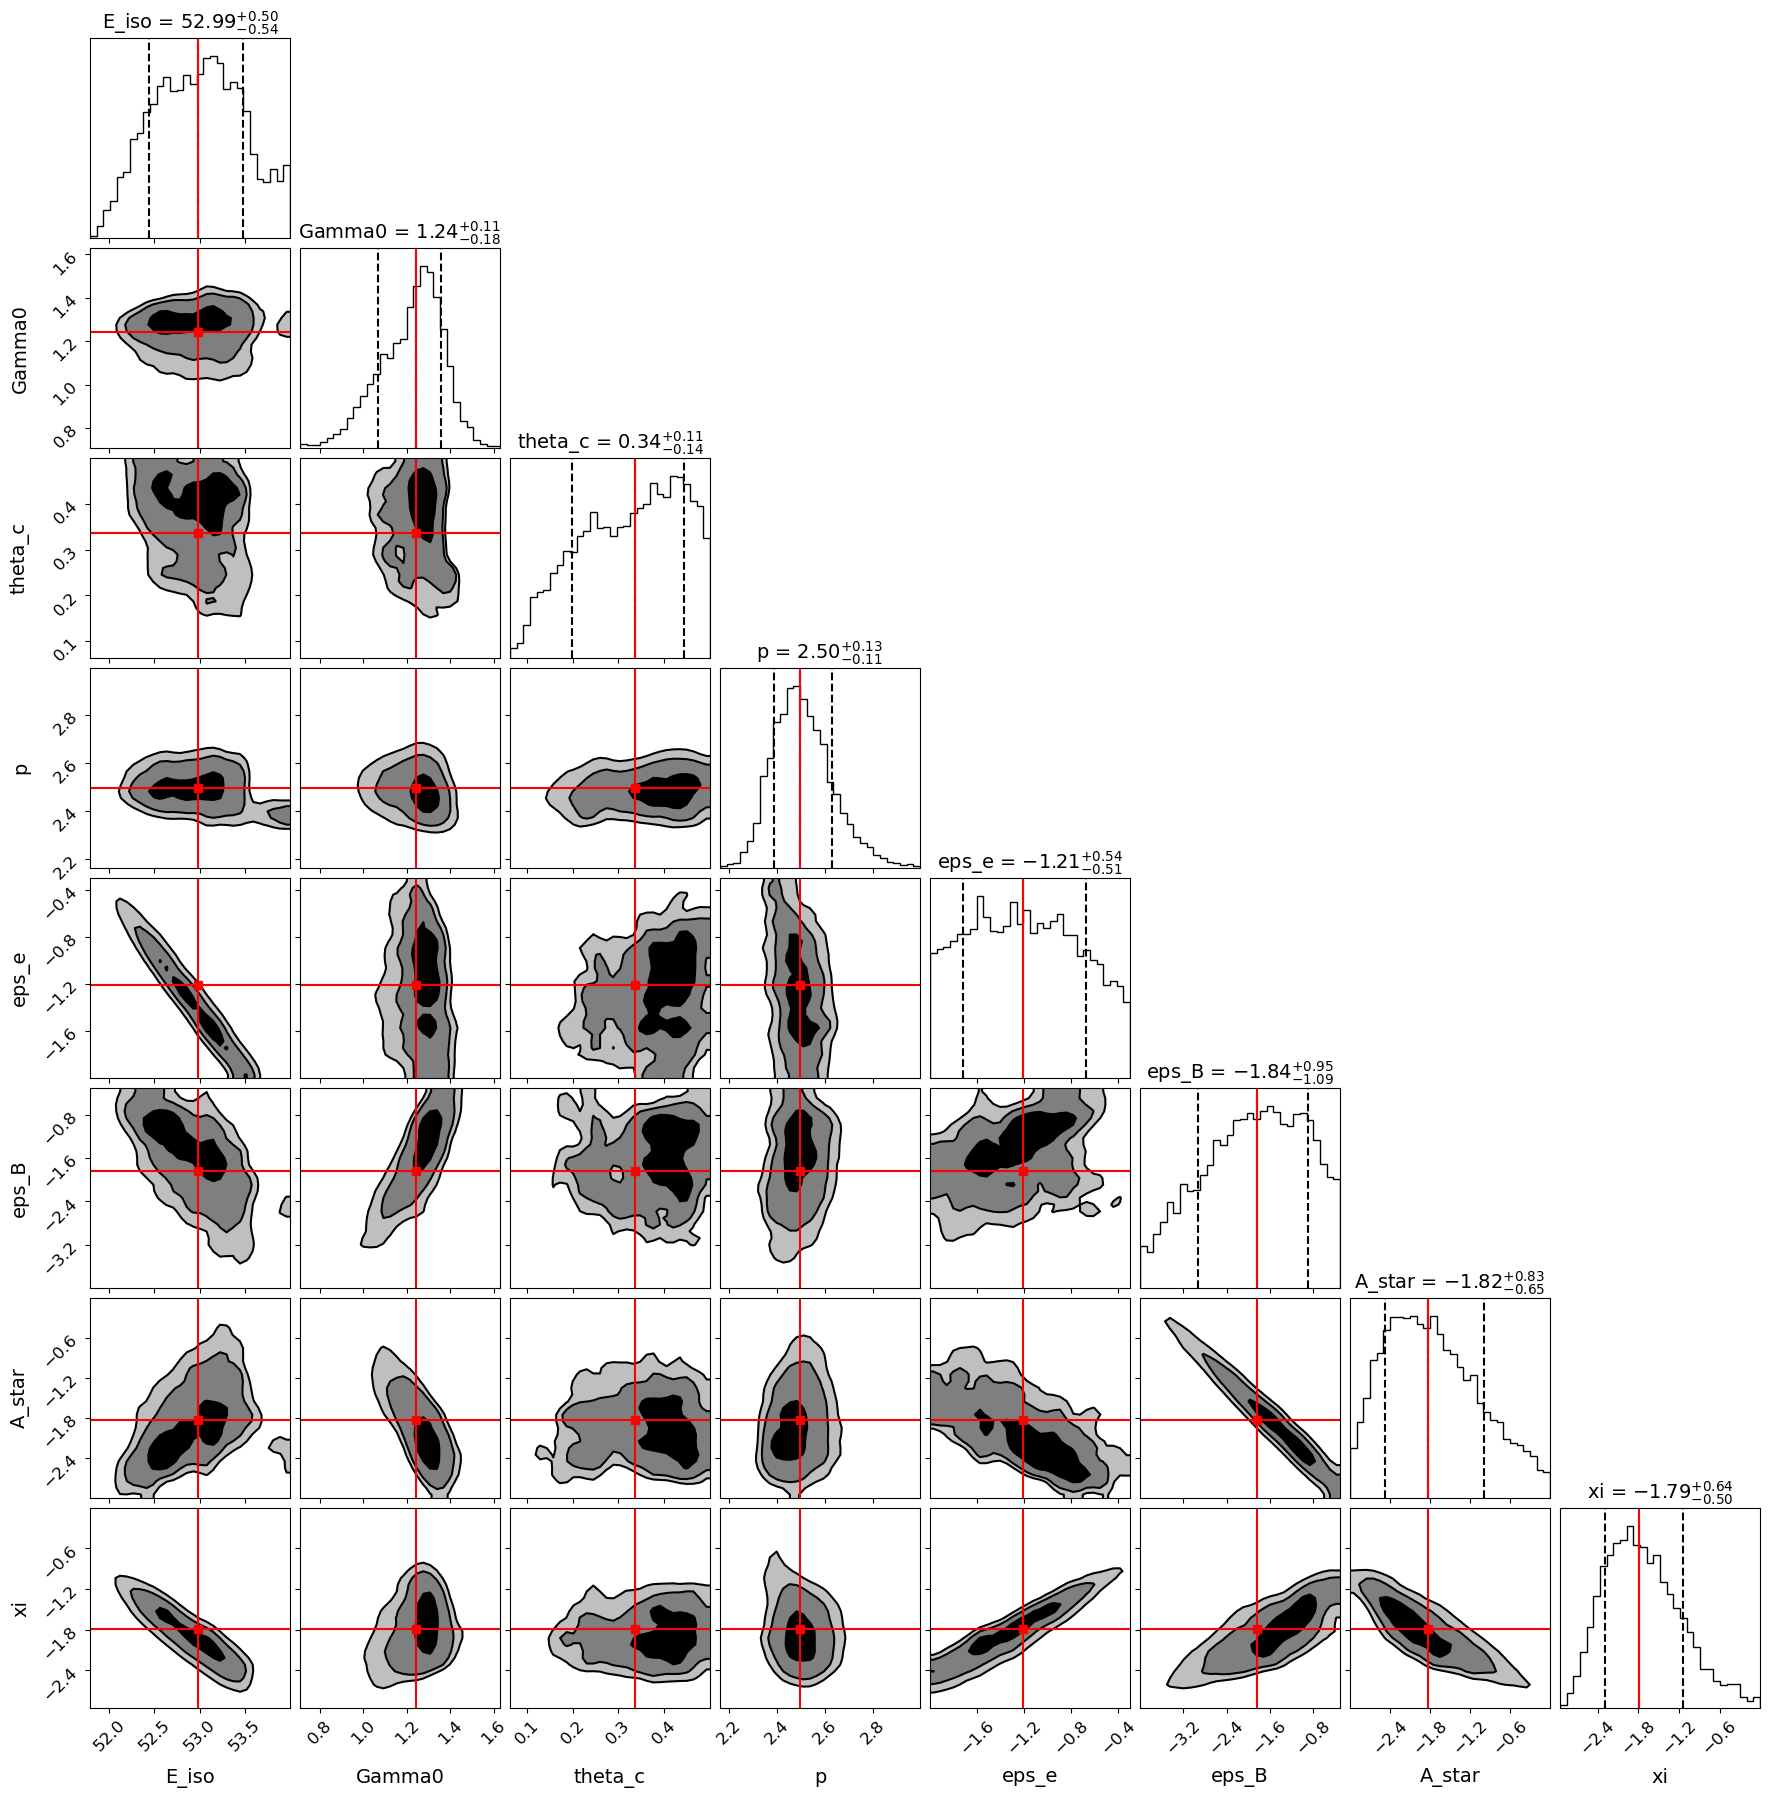

In [9]:
import matplotlib.pyplot as plt
import corner
import numpy as np

def plot_corner(flat_chain, labels, filename="corner_plot.png"):
    fig = corner.corner(
        flat_chain,
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],  # For median and ±1σ
        show_titles=True,
        title_kwargs={"fontsize": 14},
        label_kwargs={"fontsize": 14},
    #range=ranges,  # Optional: constrain plot ranges
        truths=np.median(flat_chain, axis=0),  # Show median values
        truth_color='red',
        bins=30,  # Number of bins in histograms
        smooth=1.0,  # Smoothing factor
        plot_datapoints=False,
        fill_contours=True,
        levels=[0.16, 0.5, 0.68],  # 1σ and 2σ contours
        color='k',
        alpha=0.5
    )
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12) 
    fig.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"📊 Corner plot saved to: {filename}")

def plot_trace(chain, labels, filename="trace_plot.png"):
    nsteps, nwalkers, ndim = chain.shape
    fig, axes = plt.subplots(ndim, figsize=(10, 2.5 * ndim), sharex=True)

    for i in range(ndim):
        for j in range(nwalkers):
            axes[i].plot(chain[:, j, i], alpha=1,lw=0.5)
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True)
    
    axes[-1].set_xlabel("Step")
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"📉 Trace plot saved to: {filename}")

#data = np.load("mcmc_results54-refine.npz")
#chain = data["chain"]
#labels = data["labels"]

#plot_trace(result.samples, result.labels, filename="trace_plot.png")

flat_chain = result.samples.reshape(-1, result.samples.shape[-1])

plot_corner(flat_chain, result.labels, filename="corner_plot_g.png")